# CNN With Fashion Data
 An x layer CNN for fashion (clothing?) type detection trained
 on an MNIST dataset from Zolando Research

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline  
# what does this ^ mean?

np.random.seed(2)  # number of epochs? (steps)


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix  # look this up
import itertools

from keras.utils.np_utils import to_categorical  # "convert to one-hot-encoding??"
from keras.models  import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D  #Layers of Network?
from keras.optimizers import RMSprop  # look this up
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style = 'dark', context = 'notebook', palette = 'deep')

/Users/chance/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

In [3]:
# digit recognizer tutorial's 'test' doesn't have a 'label'
# column, but this fashion data has a label column on both
# the test and train data, need to drop from both when checking
# checking for missing or corrupted images

7    1000
6    1000
5    1000
4    1000
3    1000
2    1000
9    1000
1    1000
8    1000
0    1000
Name: label, dtype: int64

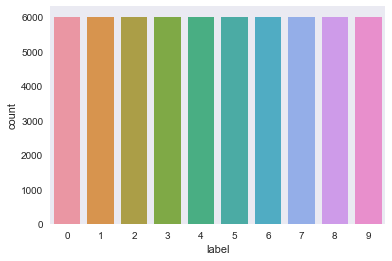

In [4]:
Y_train = train['label']
X_train = train.drop(labels = ['label'], axis = 1) 
Y_test = test['label']
X_test = test.drop(labels = ['label'], axis = 1)
del train #freeing space? (taking less time for model training?)
del test
g = sns.countplot(Y_train)
g1 = sns.countplot(Y_test)
Y_train.value_counts()
Y_test.value_counts()

In [5]:
# Is this ^ all supposed to be the same count? 
# Why is there only one plot?

In [6]:
X_train.isnull().any().describe() # checking train for missing data

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
X_test.isnull().any().describe() # checking test for missing data

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
# Missing data returned as True ('top')?

In [9]:
X_train = X_train / 255.0  # Can I pick another number besides
X_test =  X_test / 255.0   # 255.0 for slower convergence when
                           # normalizing the data?
                    

In [10]:
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)
# Reshaping in 3 dimensions, but what is the -1?

In [11]:
# Create dictionary of target classes
label_dict = {
 0: 'Cute_lil_top',
 1: 'Hot_pants',
 2: 'Hoodie',
 3: 'Dress_Up',
 4: 'Bundles_up_bitches',
 5: 'Toe_flaunters',
 6: 'Shirt',
 7: 'Sneakaaas',
 8: 'Hold_my_purse',
 9: 'Booties'
}

In [12]:
#wtf is label encoding?! Robot binary talk?
Y_train = to_categorical(Y_train, num_classes = 10)


In [13]:
random_seed = 2
#Split training and make validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)
                                                                    # ^10% of this data validated, 90% for training            

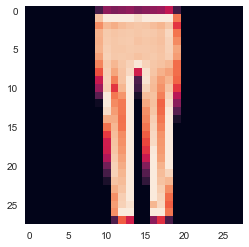

In [14]:
g = plt.imshow(X_train[42985][:,:,0])

In [15]:
#Setting CNN Model

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',
                activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))


In [16]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

In [17]:
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [24]:
epochs = 50 # Changing Epochs doesn't necessarily improve accuracy in this data's case
batch_size = 86  # Why 86?

In [25]:
# With Data Augmentation 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# Fitting Model With Data Augmentation

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
 - 300s - loss: 0.7964 - acc: 0.7241 - val_loss: 0.4429 - val_acc: 0.8543
Epoch 2/50
 - 310s - loss: 0.7797 - acc: 0.7289 - val_loss: 0.8106 - val_acc: 0.8348
Epoch 3/50
 - 302s - loss: 0.7545 - acc: 0.7355 - val_loss: 0.5782 - val_acc: 0.8630
Epoch 4/50
 - 302s - loss: 0.7451 - acc: 0.7416 - val_loss: 0.4984 - val_acc: 0.8415
Epoch 5/50
 - 300s - loss: 0.7456 - acc: 0.7430 - val_loss: 0.5646 - val_acc: 0.8522
Epoch 6/50
 - 304s - loss: 0.7310 - acc: 0.7462 - val_loss: 0.5939 - val_acc: 0.8280

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
 - 308s - loss: 0.6516 - acc: 0.7663 - val_loss: 0.4508 - val_acc: 0.8627
Epoch 8/50
 - 299s - loss: 0.6443 - acc: 0.7706 - val_loss: 0.4236 - val_acc: 0.8617
Epoch 9/50
 - 304s - loss: 0.6362 - acc: 0.7725 - val_loss: 0.5062 - val_acc: 0.8608

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 10/50
 - 301s - loss: 0.6002 - acc: 0.7851 - val_loss: 0.4685 - val

In [20]:
# Without Data Augmentation (Fitting model)

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val), verbose = 2)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
 - 284s - loss: 0.5105 - acc: 0.8159 - val_loss: 0.2979 - val_acc: 0.8922
Epoch 2/100
 - 283s - loss: 0.3189 - acc: 0.8867 - val_loss: 0.2880 - val_acc: 0.9010
Epoch 3/100
 - 282s - loss: 0.2838 - acc: 0.8993 - val_loss: 0.2397 - val_acc: 0.9112
Epoch 4/100
 - 281s - loss: 0.2668 - acc: 0.9040 - val_loss: 0.2303 - val_acc: 0.9177
Epoch 5/100
 - 281s - loss: 0.2572 - acc: 0.9086 - val_loss: 0.2240 - val_acc: 0.9168
Epoch 6/100
 - 283s - loss: 0.2513 - acc: 0.9119 - val_loss: 0.2353 - val_acc: 0.9143
Epoch 7/100
 - 283s - loss: 0.2488 - acc: 0.9118 - val_loss: 0.2334 - val_acc: 0.9130
Epoch 8/100
 - 282s - loss: 0.2454 - acc: 0.9125 - val_loss: 0.2217 - val_acc: 0.9195
Epoch 9/100
 - 282s - loss: 0.2480 - acc: 0.9136 - val_loss: 0.2222 - val_acc: 0.9200
Epoch 10/100
 - 281s - loss: 0.2425 - acc: 0.9164 - val_loss: 0.2307 - val_acc: 0.9200
Epoch 11/100
 - 282s - loss: 0.2434 - acc: 0.9154 - val_loss: 0.2545 - val_acc: 0.9138
Epo

Epoch 95/100
 - 289s - loss: 0.4065 - acc: 0.8700 - val_loss: 0.3501 - val_acc: 0.8817
Epoch 96/100
 - 289s - loss: 0.4159 - acc: 0.8684 - val_loss: 0.2906 - val_acc: 0.9022
Epoch 97/100
 - 288s - loss: 0.4086 - acc: 0.8705 - val_loss: 0.2847 - val_acc: 0.9008
Epoch 98/100
 - 287s - loss: 0.4263 - acc: 0.8657 - val_loss: 0.2997 - val_acc: 0.8945
Epoch 99/100
 - 285s - loss: 0.4267 - acc: 0.8664 - val_loss: 0.3059 - val_acc: 0.9002
Epoch 100/100
 - 286s - loss: 0.4136 - acc: 0.8692 - val_loss: 0.3570 - val_acc: 0.8942


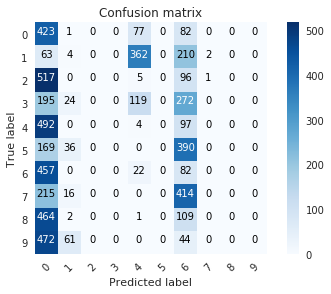

In [17]:
# Confusion Matrix (also needed for error display)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

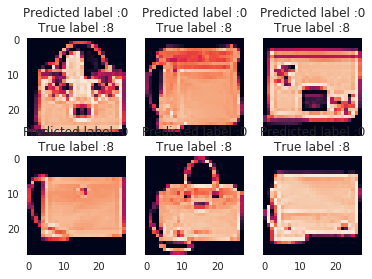

In [18]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [19]:
# predict results
results = model.predict(X_test)


# select the index with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

